In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

In [67]:
df = pd.read_csv('final_selected_variables.csv')

In [68]:
df = df.drop('Unnamed: 0',axis = 1)

In [118]:
df1 = df[(df.Recnum <=84299) & (df.Recnum >= 3338)]
df2 = df[df.Recnum >= 84300]

In [119]:
df1 = df1.set_index('Recnum')
df2 = df2.set_index('Recnum')

In [133]:
X = df1.drop(['Fraud'], axis = 1)
Y = df1['Fraud']
x_oot = df2.drop(['Fraud'], axis = 1)
y_oot = df2['Fraud']

In [134]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size = 0.3)

In [135]:
rf = RandomForestRegressor(n_estimators = 100, max_depth = 10, max_features = 'sqrt', bootstrap = True)
rf.fit(x_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [136]:
def FDR(x,y,model):
    pred = model.predict(x)
    y_df = pd.DataFrame(y)
    y_df['pred'] = pred
    top = int(len(y_df) * 0.03)
    numbads = sum(y_df['Fraud'] == 1)
    fdr = y_df.sort_values(by = 'pred', ascending = False).head(top).Fraud.sum()/numbads
    return fdr

In [137]:
FDR(x_train,y_train,rf)

0.9259868421052632

In [138]:
FDR(x_test,y_test,rf)

0.8730769230769231

In [139]:
FDR(x_oot,y_oot,rf)

0.5586592178770949

In [140]:
importance = pd.DataFrame({'columns':list(x_train.columns), 'importance':rf.feature_importances_})

In [141]:
importance.sort_values('importance', ascending = False, inplace = True)

In [142]:
importance

,columns,importance
12,cardnum-merch_state_merch_zip_count3__sum,0.102928
19,cardnum-merchnum_count3__sum,0.097396
8,cardnum-merch_description_part_count3__sum,0.084461
3,Merchnum_count1__sum,0.083576
6,cardnum-merch_description_part_count14__sum,0.072808
14,cardnum-merchnum_count14__max,0.063501
15,cardnum-merchnum_count14__sum,0.051556
13,cardnum-merch_zip_count14__max,0.048256
10,cardnum-merch_state_count30__max,0.043491
5,cardnum-merch_description_part_count14__max,0.043431


In [143]:
def modelpop(x,y,model):
    train_pred = model.predict(x)
    train_data = x
    train_data['Fraud'] = y.to_frame()['Fraud']
    train_data['pred'] = train_pred
    train_data.sort_values('pred', ascending = False, inplace = True)

    GoodTest=sum(train_data['Fraud']==0)
    BadTest=sum(train_data['Fraud']==1)

    r=0
    l=[]
    culgood=0
    culbad=0

    for i in range(100):
        data=train_data.iloc[r:min(int((i+1)*len(train_data)/100),len(train_data)),]
        populationbin=i+ 1
        numofrecord=len(data)
        numofgood=sum(data['Fraud']==0)
        numofbads=sum(data['Fraud']==1)
        percentagegood=numofgood/GoodTest*100
        percentagebad=numofbads/BadTest*100
        numofrecord=min(int((i+1)*len(train_data)/100),len(train_data))-r
        totalrecord=min(int((i+1)*len(train_data)/100),len(train_data))
        culgood+=numofgood
        culbad+=numofbads
        culpergood=culgood/GoodTest*100
        culperbad=culbad/BadTest*100
        KS=culperbad-culpergood
        FPR=culpergood/culperbad
        r= min(int((i+1)*len(train_data)/100),len(train_data))
        last_score = data.tail(1)[['pred']].values[0][0]
        l.append([populationbin,numofrecord,numofgood,numofbads,percentagegood,percentagebad,totalrecord,culgood,culbad,culpergood,culperbad,KS,FPR,last_score])

    l=pd.DataFrame(l,columns=['Population Bin%','#Records','#Goods','#Bads','%Goods','%Bads','Total#Records','Cumulative Goods','Cumulative Bads','%Goods','%Bads (FDR)','KS','FPR','Min Fraudscore'])
    return l

In [144]:
train_pop = modelpop(x_train,y_train, rf)
test_pop = modelpop(x_test,y_test, rf)
oot_pop = modelpop(x_oot,y_oot, rf)

/Users/nianzhe/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/nianzhe/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/nianzhe/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

In [145]:
with pd.ExcelWriter('Result_Distribution_5.xlsx') as writer:  
    train_pop.to_excel(writer, sheet_name='Train')
    test_pop.to_excel(writer, sheet_name='Test')
    oot_pop.to_excel(writer, sheet_name='OOT')

### Fraud Score Increase Plot

In [20]:
pred_use = df.set_index('Recnum').drop('Fraud',axis = 1)

In [21]:
pred_use['pred_score'] = rf.predict(pred_use)

In [22]:
X = pred_use[['pred_score']]

In [23]:
cal = pd.read_excel('no_missing.xlsx', parse_date = True)

In [24]:
cal.head()

,Unnamed: 0,assign,Merch_description,Merchnum,Recnum,Cardnum,Date,Merch_state,Merch_zip,Amount,Fraud,Merch_description_part,minus
0,0,FEDEX SHP 12/23/09 AB#TN38118,FEDEX SHP 12/23/09 AB#,5509006296254,1,5142190439,2010-01-01,TN,38118,3.62,0,FEDEXSHPAB,-1
1,1,SERVICE MERCHANDISE #81MA01803,SERVICE MERCHANDISE #81,61003026333,2,5142183973,2010-01-01,MA,1803,31.42,0,SERVICEMERCHANDISE,-2
2,2,OFFICE DEPOT #191MD20706,OFFICE DEPOT #191,4503082993600,3,5142131721,2010-01-01,MD,20706,178.49,0,OFFICEDEPOT,-3
3,3,FEDEX SHP 12/28/09 AB#TN38118,FEDEX SHP 12/28/09 AB#,5509006296254,4,5142148452,2010-01-01,TN,38118,3.62,0,FEDEXSHPAB,-4
4,4,FEDEX SHP 12/23/09 AB#TN38118,FEDEX SHP 12/23/09 AB#,5509006296254,5,5142190439,2010-01-01,TN,38118,3.62,0,FEDEXSHPAB,-5


In [25]:
dt1 = cal[['Cardnum','Recnum']]
dt2 = cal[['Cardnum','Recnum']]

In [26]:
dt3 = pd.merge(dt1, dt2, left_on = 'Cardnum', right_on = 'Cardnum')

In [27]:
dt3 = dt3[dt3.Recnum_y <= dt3.Recnum_x]

In [28]:
dt3 = dt3.groupby('Recnum_x').count()

In [29]:
dt3 = dt3.reset_index()

In [30]:
dt3 = dt3[['Recnum_x','Cardnum']]

In [31]:
dt3.columns = ['Recnum', 'Cardnum_Freq']

In [32]:
dt3

,Recnum,Cardnum_Freq
0,1,1
1,2,1
2,3,1
3,4,1
4,5,2
...,...,...
96392,96749,4
96393,96750,200
96394,96751,140
96395,96752,45


In [33]:
dt4 = cal[['Merchnum','Recnum']]
dt5 = cal[['Merchnum','Recnum']]
dt6 = pd.merge(dt4, dt5, left_on = 'Merchnum', right_on = 'Merchnum')
dt6 = dt6[dt6.Recnum_y <= dt6.Recnum_x]
dt6 = dt6.groupby('Recnum_x').count()
dt6 = dt6.reset_index()
dt6 = dt6[['Recnum_x','Merchnum']]
dt6.columns = ['Recnum', 'Merchnum_Freq']

In [34]:
dt6

,Recnum,Merchnum_Freq
0,1,1
1,2,1
2,3,1
3,4,2
4,5,3
...,...,...
96392,96749,1
96393,96750,41
96394,96751,219
96395,96752,479


In [35]:
date = cal[['Recnum','Date', 'Cardnum', 'Merchnum']]

In [36]:
final = pd.merge(X, date, left_index = True, right_on = 'Recnum')

In [37]:
final = pd.merge(final, dt3, left_on = 'Recnum', right_on = 'Recnum')

In [38]:
final = pd.merge(final, dt6, left_on = 'Recnum', right_on = 'Recnum')

In [39]:
final = final.set_index('Recnum')

In [70]:
## final.to_csv('Plot_use.csv')

## Plot with time and frequency

In [40]:
final.columns = ['Fraud Score', 'Date', 'Cardnum', 'Merchnum', 'Cardnum_Freq',
       'Merchnum_Freq']

In [41]:
final

,Fraud Score,Date,Cardnum,Merchnum,Cardnum_Freq,Merchnum_Freq
Recnum,,,,,,
1,0.000760,2010-01-01,5142190439,5509006296254,1,1
2,0.000696,2010-01-01,5142183973,61003026333,1,1
3,0.000723,2010-01-01,5142131721,4503082993600,1,1
4,0.000760,2010-01-01,5142148452,5509006296254,1,2
5,0.000760,2010-01-01,5142190439,5509006296254,2,3
...,...,...,...,...,...,...
96749,0.000609,2010-12-31,5142276053,3500000006160,4,1
96750,0.000927,2010-12-31,5142225701,8090710030950,200,41
96751,0.006255,2010-12-31,5142226486,4503057341100,140,219


In [42]:
Cardnum_list = final.sort_values(by = 'Fraud Score', ascending = False)['Cardnum'].head(10).to_list()
Merchnum_list = final.sort_values(by = 'Fraud Score', ascending = False)['Merchnum'].head(10).to_list()

In [43]:
Cardnum_list

[5142179617,
 5142176939,
 5142271065,
 5142249750,
 5142271065,
 5142271065,
 5142271065,
 5142271065,
 5142271065,
 5142271065]

In [44]:
import matplotlib.pyplot as plt

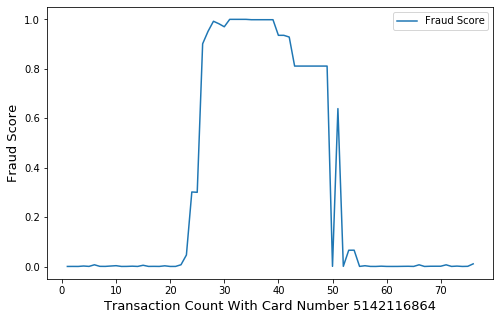

In [45]:
plt.rcParams["figure.figsize"] = [8,5]
final[final['Cardnum'] ==5142116864 ][['Fraud Score','Cardnum_Freq']].plot.line(x='Cardnum_Freq', y='Fraud Score')
plt.xlabel('Transaction Count With Card Number 5142116864',fontsize=13)
plt.ylabel('Fraud Score',fontsize=13)
plt.savefig('pic/result_card_count_fraud.png')

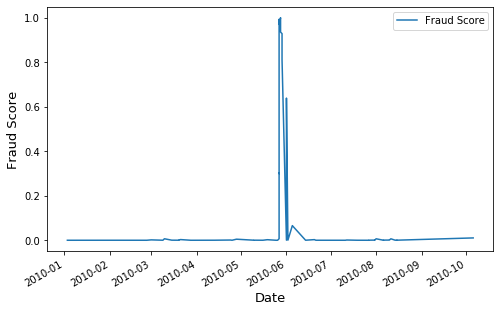

In [46]:
final[final['Cardnum'] ==5142116864][['Fraud Score','Date']].plot.line(x='Date', y='Fraud Score')
plt.xlabel('Date', fontsize = 13)
plt.ylabel('Fraud Score', fontsize = 13)
plt.savefig('pic/result_card_date_fraud.png')

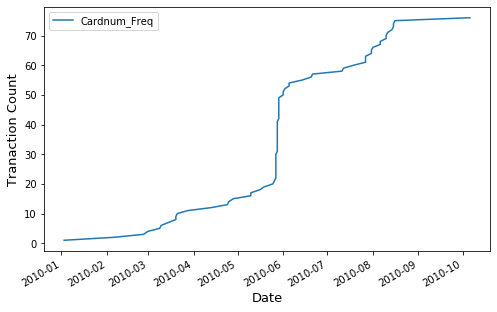

In [47]:
final[final['Cardnum'] ==5142116864][['Cardnum_Freq','Date']].plot.line(x='Date', y='Cardnum_Freq')
plt.xlabel('Date', fontsize = 13)
plt.ylabel('Tranaction Count', fontsize = 13)
plt.savefig('pic/result_card_date_count.png')

In [48]:
Merchnum_list

['253052983001',
 '4503082476300',
 '4620009957157',
 '92891948003',
 '4620009957157',
 '4620009957157',
 '4620009957157',
 '4620009957157',
 '4620009957157',
 '4620009957157']

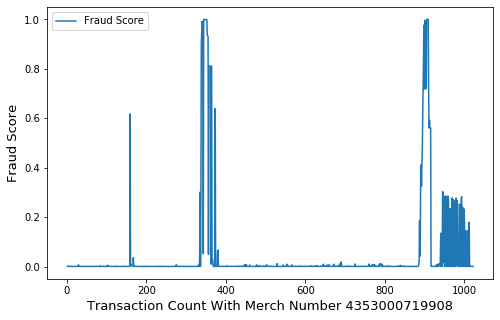

In [50]:
final[final['Merchnum'] =='4353000719908'][['Fraud Score','Merchnum_Freq']].plot.line(x='Merchnum_Freq', y='Fraud Score')
plt.xlabel('Transaction Count With Merch Number 4353000719908',fontsize=13)
plt.ylabel('Fraud Score',fontsize=13)
plt.savefig('pic/result_merch_count_fraud.png')

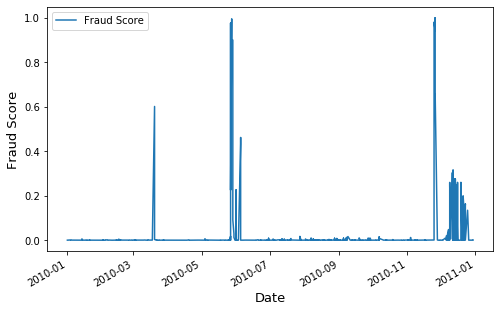

In [147]:
final[final['Merchnum'] =='4353000719908'][['Fraud Score','Date']].plot.line(x='Date', y='Fraud Score')
plt.xlabel('Date', fontsize = 13)
plt.ylabel('Fraud Score', fontsize = 13)
plt.savefig('pic/result_merch_date_fraud.png')

In [63]:
f = final[final['Date'].map(lambda x: x.month) >= 5]
f = f[f['Date'].map(lambda x: x.month) <= 6]

Text(0, 0.5, 'Tranaction Count')

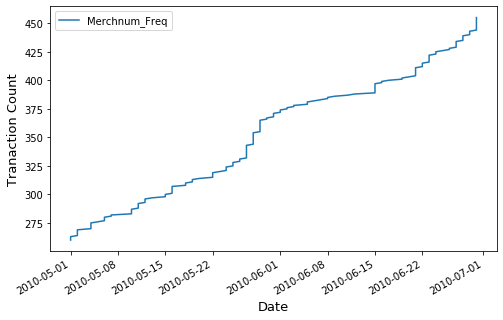

In [64]:
f[f['Merchnum'] =='4353000719908'][['Merchnum_Freq','Date']].plot.line(x='Date', y='Merchnum_Freq')
plt.xlabel('Date', fontsize = 13)
plt.ylabel('Tranaction Count', fontsize = 13)

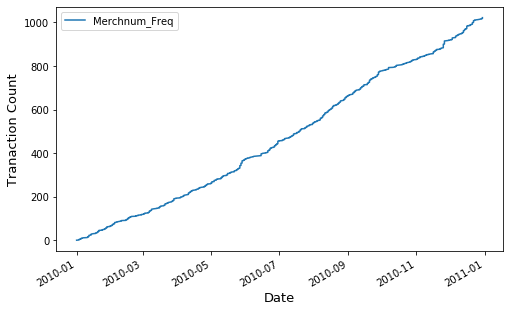

In [148]:
final[final['Merchnum'] =='4353000719908'][['Merchnum_Freq','Date']].plot.line(x='Date', y='Merchnum_Freq')
plt.xlabel('Date', fontsize = 13)
plt.ylabel('Tranaction Count', fontsize = 13)
plt.savefig('pic/result_merch_date_count.png')

# Below Don't Run Again!!!

## Parameters Grid Search

In [165]:
X = df1.drop(['Fraud'], axis = 1)
Y = df1['Fraud']

In [60]:
max_depth_list = [8,10,13,18]
## min_samples_split_list = [2,10]
max_features_list = ['auto','sqrt','log2']
## min_samples_leaf_list = [1,10,20]
bootstrap_list = [True, False]
n_estimators_list = [50,100,150]

In [61]:
result = pd.DataFrame(columns = ['index','max_depth','max_features',
                                'bootstrap','n_estimators','fdr_trian','fdr_test','fdr_oot'])

In [62]:
result

,index,max_depth,max_features,bootstrap,n_estimators,fdr_trian,fdr_test,fdr_oot


In [63]:
i = 0
for depth in max_depth_list:
    for feature in max_features_list:
        for boot in bootstrap_list:
            for n in n_estimators_list:
                for index in range(10):
                    x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size = 0.3)
                    rf = RandomForestRegressor(n_estimators = n, max_depth = depth, max_features = feature, bootstrap = boot)
                    rf.fit(x_train,y_train)
                    fdr_train = FDR(x_train,y_train,rf)
                    fdr_test = FDR(x_test,y_test,rf)
                    fdr_oot = FDR(x_oot,y_oot,rf)
                    dic = {'index':index+1,'max_depth':depth,'max_features':feature,
                                'bootstrap':boot,'n_estimators':n,'fdr_trian':fdr_train,'fdr_test':fdr_test,'fdr_oot':fdr_oot}
                    result = result.append(dic,ignore_index = True)
                    print(i)
                    i = i+1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [64]:
result

,index,max_depth,max_features,bootstrap,n_estimators,fdr_trian,fdr_test,fdr_oot
0,1,8,auto,True,50,0.858086,0.828244,0.569832
1,2,8,auto,True,50,0.845395,0.769231,0.541899
2,3,8,auto,True,50,0.848142,0.815261,0.547486
3,4,8,auto,True,50,0.866889,0.808989,0.541899
4,5,8,auto,True,50,0.858075,0.811765,0.530726
...,...,...,...,...,...,...,...,...
715,6,18,log2,False,150,1.000000,0.890152,0.553073
716,7,18,log2,False,150,1.000000,0.853047,0.525140
717,8,18,log2,False,150,1.000000,0.885106,0.558659
718,9,18,log2,False,150,1.000000,0.878151,0.519553


In [83]:
result_avg = result.groupby(['max_depth','max_features','bootstrap','n_estimators']).agg({'fdr_trian':'mean','fdr_test':'mean','fdr_oot':'mean'})

In [84]:
result_avg = result_avg.reset_index()

In [85]:
with pd.ExcelWriter('Result_RF.xlsx') as writer:  
    result_avg.to_excel(writer, sheet_name='Average_Result')
    result.to_excel(writer, sheet_name='All_result')